# Prediction taxi trajectory

I tried prediction, taxi service trajectory.

### agenda
- Data loading and Data check
- EDA
- Data preprocessing
- Prediction with Random forest regression
- Validation
- Submitting

## Libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')

# Directry check
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pkdd-15-predict-taxi-service-trajectory-i/train.csv.zip
/kaggle/input/pkdd-15-predict-taxi-service-trajectory-i/sampleSubmission.csv.zip
/kaggle/input/pkdd-15-predict-taxi-service-trajectory-i/test.csv.zip
/kaggle/input/pkdd-15-predict-taxi-service-trajectory-i/evaluation_script.r
/kaggle/input/pkdd-15-predict-taxi-service-trajectory-i/metaData_taxistandsID_name_GPSlocation.csv.zip


In [2]:
# file
import zipfile

# Data preprocessing
import datetime
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Visualization
from matplotlib import pyplot as plt
import folium
import seaborn as sns

# Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# parameter opimization
from sklearn.model_selection import GridSearchCV

# Validation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [3]:
## Dataloading

In [4]:
# sample
zip_file = zipfile.ZipFile("/kaggle/input/pkdd-15-predict-taxi-service-trajectory-i/sampleSubmission.csv.zip")
sample = pd.read_csv(zip_file.open('sampleSubmission.csv'))

In [5]:
# train
zip_file = zipfile.ZipFile("/kaggle/input/pkdd-15-predict-taxi-service-trajectory-i/train.csv.zip")
train_df = pd.read_csv(zip_file.open("train.csv"))

In [6]:
# test
zip_file = zipfile.ZipFile("/kaggle/input/pkdd-15-predict-taxi-service-trajectory-i/test.csv.zip")
test_df = pd.read_csv(zip_file.open("test.csv"))

In [7]:
# location_Data
zip_file = zipfile.ZipFile("/kaggle/input/pkdd-15-predict-taxi-service-trajectory-i/metaData_taxistandsID_name_GPSlocation.csv.zip")
loc_df = pd.read_csv(zip_file.open("metaData_taxistandsID_name_GPSlocation.csv"))

## Data checking

In [8]:
# sample_submission
sample.head()

TRIP_ID   LATITUDE  LONGITUDE
0      T1  41.146504  -8.611317
1      T2  41.146504  -8.611317
2      T3  41.146504  -8.611317
3      T4  41.146504  -8.611317
4      T5  41.146504  -8.611317

In [9]:
# test_data
test_df.head()

TRIP_ID CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND   TAXI_ID   TIMESTAMP DAY_TYPE  \
0      T1         B          NaN          15.0  20000542  1408039037        A   
1      T2         B          NaN          57.0  20000108  1408038611        A   
2      T3         B          NaN          15.0  20000370  1408038568        A   
3      T4         B          NaN          53.0  20000492  1408039090        A   
4      T5         B          NaN          18.0  20000621  1408039177        A   

   MISSING_DATA                                           POLYLINE  
0         False  [[-8.585676,41.148522],[-8.585712,41.148639],[...  
1         False  [[-8.610876,41.14557],[-8.610858,41.145579],[-...  
2         False  [[-8.585739,41.148558],[-8.58573,41.148828],[-...  
3         False  [[-8.613963,41.141169],[-8.614125,41.141124],[...  
4         False      [[-8.619903,41.148036],[-8.619894,41.148036]]

In [10]:
# test_data size
test_df.shape

(320, 9)

In [11]:
# train_data
train_df.head()

TRIP_ID CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND   TAXI_ID  \
0  1372636858620000589         C          NaN           NaN  20000589   
1  1372637303620000596         B          NaN           7.0  20000596   
2  1372636951620000320         C          NaN           NaN  20000320   
3  1372636854620000520         C          NaN           NaN  20000520   
4  1372637091620000337         C          NaN           NaN  20000337   

    TIMESTAMP DAY_TYPE  MISSING_DATA  \
0  1372636858        A         False   
1  1372637303        A         False   
2  1372636951        A         False   
3  1372636854        A         False   
4  1372637091        A         False   

                                            POLYLINE  
0  [[-8.618643,41.141412],[-8.618499,41.141376],[...  
1  [[-8.639847,41.159826],[-8.640351,41.159871],[...  
2  [[-8.612964,41.140359],[-8.613378,41.14035],[-...  
3  [[-8.574678,41.151951],[-8.574705,41.151942],[...  
4  [[-8.645994,41.18049],[-8.645949,41.180517],[-...

In [12]:
# train_data size
train_df.shape

(1710670, 9)

In [13]:
# train_data info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710670 entries, 0 to 1710669
Data columns (total 9 columns):
TRIP_ID         int64
CALL_TYPE       object
ORIGIN_CALL     float64
ORIGIN_STAND    float64
TAXI_ID         int64
TIMESTAMP       int64
DAY_TYPE        object
MISSING_DATA    bool
POLYLINE        object
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 106.0+ MB


In [14]:
# train_data null data
train_df.isnull().sum()

TRIP_ID               0
CALL_TYPE             0
ORIGIN_CALL     1345900
ORIGIN_STAND     904091
TAXI_ID               0
TIMESTAMP             0
DAY_TYPE              0
MISSING_DATA          0
POLYLINE              0
dtype: int64

In [15]:
# train_data unique values
for i in range(train_df.shape[1]):
    print('*'*50)
    print(train_df.columns[i])
    print(train_df.iloc[:,i].value_counts())

**************************************************
TRIP_ID
1397172149620000454    3
1391717369620000663    2
1385772222620000263    2
1403115272620000066    2
1395682280620000089    2
                      ..
1381496854620000676    1
1379755642620000662    1
1391324480620000430    1
1400150464620000004    1
1403071175620000484    1
Name: TRIP_ID, Length: 1710589, dtype: int64
**************************************************
CALL_TYPE
B    817881
C    528019
A    364770
Name: CALL_TYPE, dtype: int64
**************************************************
ORIGIN_CALL
2002.0     57571
63882.0     6406
2001.0      2499
13168.0     1314
6728.0      1115
           ...  
41640.0        1
41639.0        1
41637.0        1
41634.0        1
8192.0         1
Name: ORIGIN_CALL, Length: 57105, dtype: int64
**************************************************
ORIGIN_STAND
15.0    80241
57.0    50882
9.0     34818
33.0    34128
23.0    33344
        ...  
41.0      506
43.0      493
8.0       381
5.0    

In [16]:
# test_data unique values
for i in range(test_df.shape[1]):
    print('*'*50)
    print(test_df.columns[i])
    print(test_df.iloc[:,i].value_counts())

**************************************************
TRIP_ID
T166    1
T228    1
T163    1
T219    1
T152    1
       ..
T313    1
T271    1
T48     1
T21     1
T216    1
Name: TRIP_ID, Length: 320, dtype: int64
**************************************************
CALL_TYPE
C    125
B    123
A     72
Name: CALL_TYPE, dtype: int64
**************************************************
ORIGIN_CALL
2002.0     12
4785.0      2
36542.0     1
38347.0     1
48578.0     1
31208.0     1
19845.0     1
37332.0     1
86098.0     1
10640.0     1
31780.0     1
41052.0     1
72911.0     1
65127.0     1
32563.0     1
66996.0     1
10363.0     1
35304.0     1
13297.0     1
59708.0     1
62371.0     1
85224.0     1
75460.0     1
14123.0     1
49729.0     1
85698.0     1
76232.0     1
34944.0     1
2024.0      1
80148.0     1
4391.0      1
42046.0     1
53493.0     1
66812.0     1
45085.0     1
72185.0     1
61692.0     1
34651.0     1
47514.0     1
67507.0     1
44696.0     1
73870.0     1
73071.0     1
34007.0

Data overview (site copy)<br>

TRIP_ID: (String) It contains an unique identifier for each trip;<br>

CALL_TYPE: (char) It identifies the way used to demand this service. It may contain one of three possible values:<br>
‘A’ if this trip was dispatched from the central;<br>
‘B’ if this trip was demanded directly to a taxi driver on a specific stand;<br>
‘C’ otherwise (i.e. a trip demanded on a random street).<br>

ORIGIN_CALL: (integer) It contains an unique identifier for each phone number which was used to demand, at least, one service. It identifies the trip’s customer if CALL_TYPE=’A’. Otherwise, it assumes a NULL value;<br>

ORIGIN_STAND: (integer): It contains an unique identifier for the taxi stand. It identifies the starting point of the trip if CALL_TYPE=’B’. Otherwise, it assumes a NULL value;<br>

TAXI_ID: (integer): It contains an unique identifier for the taxi driver that performed each trip;<br>

TIMESTAMP: (integer) Unix Timestamp (in seconds). It identifies the trip’s start; <br>

DAYTYPE: (char) It identifies the daytype of the trip’s start. It assumes one of three possible values:<br>
‘B’ if this trip started on a holiday or any other special day (i.e. extending holidays, floating holidays, etc.);<br>
‘C’ if the trip started on a day before a type-B day;<br>
‘A’ otherwise (i.e. a normal day, workday or weekend).<br>

MISSING_DATA: (Boolean) It is FALSE when the GPS data stream is complete and TRUE whenever one (or more) locations are missing<br>

POLYLINE: (String): It contains a list of GPS coordinates (i.e. WGS84 format) mapped as a string. The beginning and the end of the string are identified with brackets (i.e. [ and ], respectively). Each pair of coordinates is also identified by the same brackets as [LONGITUDE, LATITUDE]. This list contains one pair of coordinates for each 15 seconds of trip. The last list item corresponds to the trip’s destination while the first one represents its start;

## EDA

In [17]:
# Time data preprocessing
train_df["TIMESTAMP"] = [float(time) for time in train_df["TIMESTAMP"]]
train_df["dt"] = [datetime.datetime.fromtimestamp(time, datetime.timezone.utc) for time in train_df["TIMESTAMP"]]

In [18]:
# Time data
train_df["dt"].value_counts()

2014-03-27 19:31:22+00:00    5
2014-03-27 18:49:12+00:00    5
2014-04-10 12:57:28+00:00    5
2014-05-10 03:36:53+00:00    4
2013-10-17 13:02:53+00:00    4
                            ..
2013-12-22 06:15:11+00:00    1
2013-08-25 18:43:20+00:00    1
2014-06-26 09:56:42+00:00    1
2013-12-27 07:13:12+00:00    1
2013-11-13 12:46:20+00:00    1
Name: dt, Length: 1655366, dtype: int64

In [19]:
# Time data preparation
train_df["year"] = train_df["dt"].dt.year
train_df["month"] = train_df["dt"].dt.month
train_df["day"] = train_df["dt"].dt.day
train_df["hour"] = train_df["dt"].dt.hour
train_df["min"] = train_df["dt"].dt.minute
train_df["weekday"] = train_df["dt"].dt.weekday

In [20]:
train_df.head()

TRIP_ID CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND   TAXI_ID  \
0  1372636858620000589         C          NaN           NaN  20000589   
1  1372637303620000596         B          NaN           7.0  20000596   
2  1372636951620000320         C          NaN           NaN  20000320   
3  1372636854620000520         C          NaN           NaN  20000520   
4  1372637091620000337         C          NaN           NaN  20000337   

      TIMESTAMP DAY_TYPE  MISSING_DATA  \
0  1.372637e+09        A         False   
1  1.372637e+09        A         False   
2  1.372637e+09        A         False   
3  1.372637e+09        A         False   
4  1.372637e+09        A         False   

                                            POLYLINE  \
0  [[-8.618643,41.141412],[-8.618499,41.141376],[...   
1  [[-8.639847,41.159826],[-8.640351,41.159871],[...   
2  [[-8.612964,41.140359],[-8.613378,41.14035],[-...   
3  [[-8.574678,41.151951],[-8.574705,41.151942],[...   
4  [[-8.645994,41.18049],[-8.645949,41.180517],[-...   

                         dt  year  month  day  hour  min  weekday  
0 2013-07-01 00:00:58+00:00  2013      7    1     0    0        0  
1 2013-07-01 00:08:23+00:00  2013      7    1     0    8        0  
2 2013-07-01 00:02:31+00:00  2013      7    1     0    2        0  
3 2013-07-01 00:00:54+00:00  2013      7    1     0    0        0  
4 2013-07-01 00:04:51+00:00  2013      7    1     0    4        0

### Time series visualization

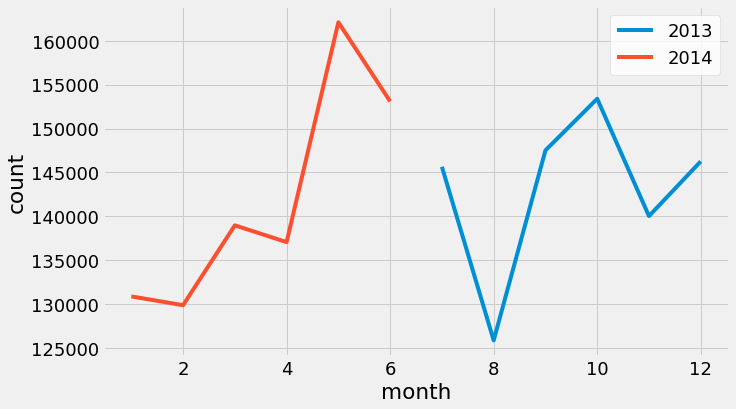

In [21]:
# Time series visualization
pivot = pd.pivot_table(train_df, index='month', columns="year", values="TRIP_ID", aggfunc="count").reset_index()

# Visualization, per month count
with plt.style.context("fivethirtyeight"):
    plt.figure(figsize=(10,6))
    plt.rcParams["font.size"] = 18
    plt.plot(pivot["month"], pivot[2013], label="2013")
    plt.plot(pivot["month"], pivot[2014], label="2014")
    plt.xlabel("month")
    plt.ylabel("count")
    plt.legend(facecolor="white")

- May is the most, and August is the lowest.

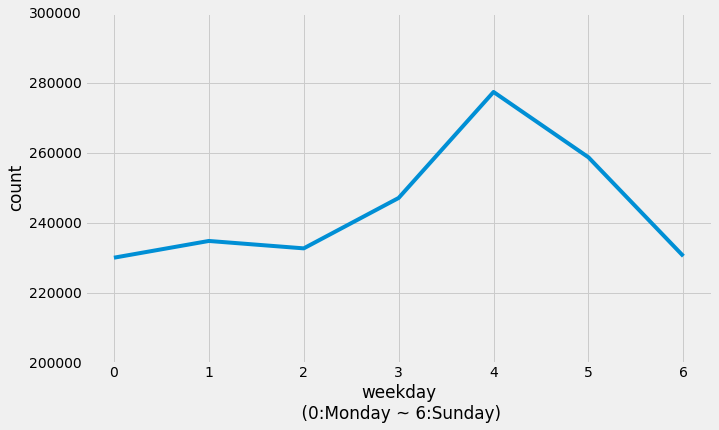

In [22]:
# weekday, groupby whole data
weekday = pd.DataFrame(data=train_df.groupby("weekday").TRIP_ID.count()).reset_index()

with plt.style.context("fivethirtyeight"):
    plt.figure(figsize=(10,6))
    
    plt.plot(weekday["weekday"], weekday["TRIP_ID"])
    plt.xlabel("weekday\n (0:Monday ~ 6:Sunday)")
    plt.ylabel("count")
    plt.ylim([200000, 300000])

- Friday is the most.

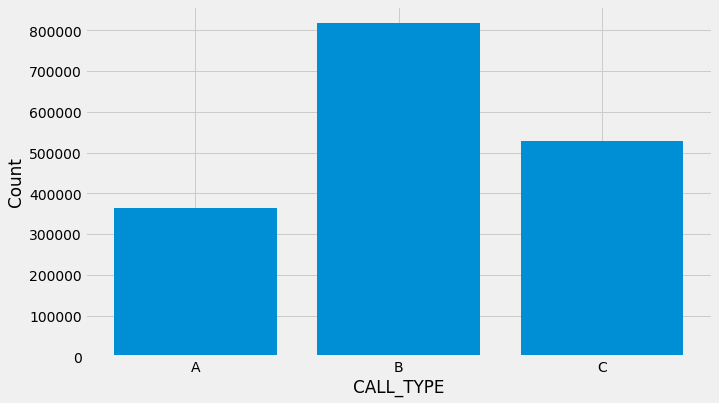

In [23]:
### Call type
call_type = pd.DataFrame(data=train_df.groupby("CALL_TYPE").TRIP_ID.count()).reset_index()

# visualization
with plt.style.context("fivethirtyeight"):
    plt.figure(figsize=(10,6))
    plt.bar(call_type["CALL_TYPE"], call_type["TRIP_ID"])
    plt.xlabel("CALL_TYPE")
    plt.ylabel("Count")

- Call type B is the most.

Sampling 1st & last ride coordinate and last coordinate

In [24]:
# 1st lon
lists_1st_lon = []
for i in range(0,len(train_df["POLYLINE"])):
    if train_df["POLYLINE"][i] == '[]':
        k=0
        lists_1st_lon.append(k)
    else:
        k = re.sub(r"[[|[|]|]|]]", "", train_df["POLYLINE"][i]).split(",")[0]
        lists_1st_lon.append(k)
        
train_df["lon_1st"] = lists_1st_lon

# 1st lat
lists_1st_lat = []
for i in range(0,len(train_df["POLYLINE"])):
    if train_df["POLYLINE"][i] == '[]':
        k=0
        lists_1st_lat.append(k)
    else:
        k = re.sub(r"[[|[|]|]|]]", "", train_df["POLYLINE"][i]).split(",")[1]
        lists_1st_lat.append(k)
        
train_df["lat_1st"] = lists_1st_lat

In [25]:
# last long
lists_last_lon = []
for i in range(0,len(train_df["POLYLINE"])):
        if train_df["POLYLINE"][i] == '[]':
            k=0
            lists_last_lon.append(k)
        else:
            k = re.sub(r"[[|[|]|]|]]", "", train_df["POLYLINE"][i]).split(",")[-2]
            lists_last_lon.append(k)

train_df["lon_last"] = lists_last_lon

# last lat
lists_last_lat = []
for i in range(0,len(train_df["POLYLINE"])):
    if train_df["POLYLINE"][i] == '[]':
        k=0
        lists_last_lat.append(k)
    else:
        k = re.sub(r"[[|[|]|]|]]", "", train_df["POLYLINE"][i]).split(",")[-1]
        lists_last_lat.append(k)
        
train_df["lat_last"] = lists_last_lat

In [26]:
# Delete lon & lat have "0".
train_df = train_df.query("lon_last != 0")

In [27]:
train_df["lon_1st"] = [float(k) for k in train_df["lon_1st"]]
train_df["lat_1st"] = [float(k) for k in train_df["lat_1st"]]
train_df["lon_last"] = [float(k) for k in train_df["lon_last"]]
train_df["lat_last"] = [float(k) for k in train_df["lat_last"]]

In [28]:
# Visualization, sampling 5000 datas.
mapping_1st = pd.DataFrame({
    "date":train_df.head(5000)["dt"].values,
    "lat":train_df.head(5000)["lat_1st"].values,
    "lon":train_df.head(5000)["lon_1st"].values
})

mapping_last = pd.DataFrame({
    "date":train_df.head(5000)["dt"].values,
    "lat":train_df.head(5000)["lat_last"].values,
    "lon":train_df.head(5000)["lon_last"].values
})

por_map = folium.Map(location=[41.141412,-8.590324], tiles='Stamen Terrain', zoom_start=11)

for i, r in mapping_1st.iterrows():
    folium.CircleMarker(location=[r["lat"],r["lon"]], radius=0.5, color="red").add_to(por_map)

for i, r in mapping_last.iterrows():
    folium.CircleMarker(location=[r["lat"],r["lon"]], radius=0.5, color="blue").add_to(por_map)    
    
por_map

- It is widely distributed, and it can be confirmed that there are many places to get in and out of the city.

Distribution of travel distance and direction<br>

delta_lon = lon_last - lon_1st<br>
delta_lat = lat_last - kat_last<br>

Confirming the plot and each distribution by sampling 5,000 point.

In [29]:
train_df["delta_lon"] = train_df["lon_last"] - train_df["lon_1st"]
train_df["delta_lat"] = train_df["lat_last"] - train_df["lat_1st"]

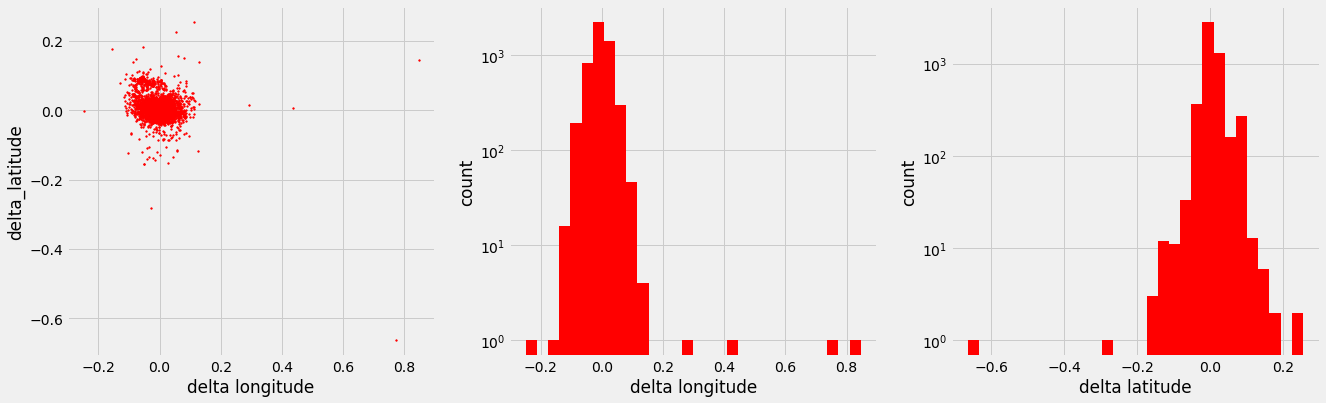

In [30]:
# sampling : 5,000 point
sample = train_df.head(5000)

with plt.style.context("fivethirtyeight"):
    fig, ax = plt.subplots(1,3,figsize=(20, 6))
    
    # plot
    ax[0].scatter(sample["delta_lon"], sample["delta_lat"], s=3, c="red")
    ax[0].set_xlabel("delta longitude")
    ax[0].set_ylabel("delta_latitude")
    
    # delta longitude distribution
    ax[1].hist(sample["delta_lon"], bins=30, color="red")
    ax[1].set_xlabel("delta longitude")
    ax[1].set_ylabel("count")
    ax[1].set_yscale("log")
    
    # delta latitude distribution
    ax[2].hist(sample["delta_lat"], bins=30, color="red")
    ax[2].set_xlabel("delta latitude")
    ax[2].set_ylabel("count")
    ax[2].set_yscale("log")

- delta longtitude & latitude can be random within ±0.2. Occasionally there are values that are significantly off.

Monthly deltadistribution.<br>
Visualize the range from -0.3 to +0.3 because most of them are near fields.

In [31]:
# monthly, delta longtitude & latitude boxplot
train_df["month_str"] = [str(i) for i in train_df["month"]]

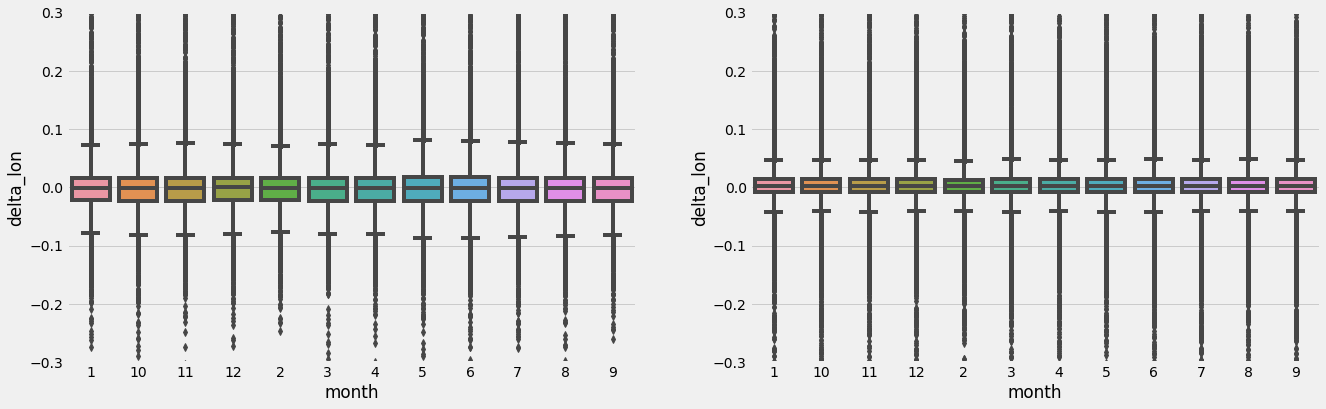

In [32]:
with plt.style.context("fivethirtyeight"):
    fig, ax = plt.subplots(1,2, figsize=(20,6))
    # delta_lon
    sns.boxplot("month_str", "delta_lon", data=train_df, ax=ax[0])
    ax[0].set_xlabel("month")
    ax[0].set_ylabel("delta_lon")
    ax[0].set_ylim([-0.3,0.3])
    # delta_lat
    sns.boxplot("month_str", "delta_lat", data=train_df, ax=ax[1])
    ax[1].set_xlabel("month")
    ax[1].set_ylabel("delta_lon")
    ax[1].set_ylim([-0.3,0.3])

Weekday distribution

In [33]:
# weekday, delta longtitude & latitude boxplot
train_df["weekday_str"] = [str(i) for i in train_df["weekday"]]

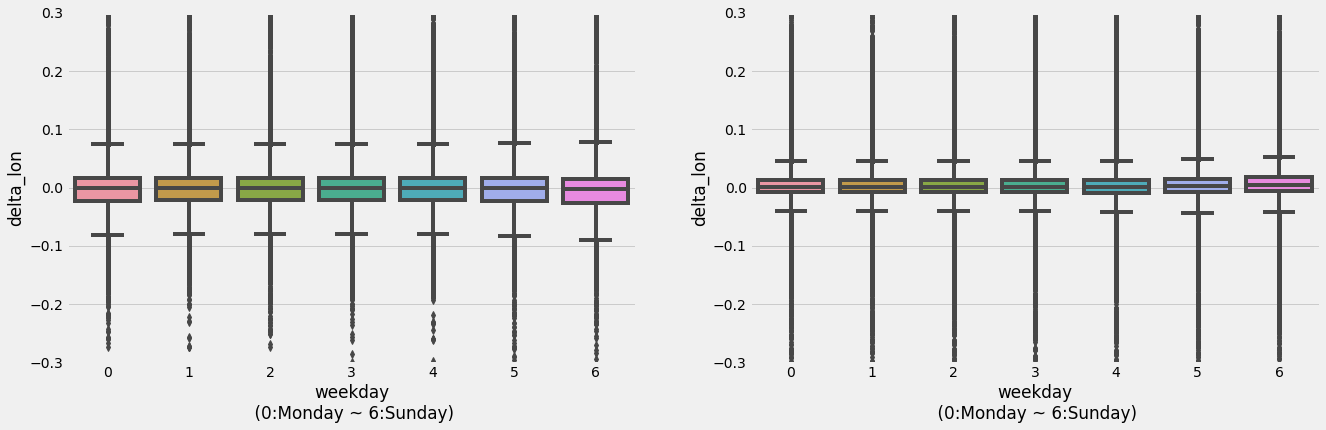

In [34]:
with plt.style.context("fivethirtyeight"):
    fig, ax = plt.subplots(1,2, figsize=(20,6))
    # delta_lon
    sns.boxplot("weekday_str", "delta_lon", data=train_df, ax=ax[0])
    ax[0].set_xlabel("weekday\n (0:Monday ~ 6:Sunday)")
    ax[0].set_ylabel("delta_lon")
    ax[0].set_ylim([-0.3,0.3])
    # delta_lat
    sns.boxplot("weekday_str", "delta_lat", data=train_df, ax=ax[1])
    ax[1].set_xlabel("weekday\n (0:Monday ~ 6:Sunday)")
    ax[1].set_ylabel("delta_lon")
    ax[1].set_ylim([-0.3,0.3])

- By month or weekday, delta longitude and delta latitude are not so different.

### Data Preprocessing

To predict the point(longitude & latitude), I tried  to change some feature categorical numerical values.
- Call type : A: 1, B: 2, C:3
- Origin_call : data exist: 1, null: 0
- Origin stand : data exist: 1, null: 0
- Day tyoe : Only A, so this variable is no used.\
- Missing data : True: 1, False=0

And Exclude outliers
- delta_lon & delta_lat : Over +0.2, or Under -0.2 is excluded.

In [35]:
# copy dataframe
df_ml = train_df.copy()

# outlier is dropped
df_ml = df_ml.query("delta_lon <= 0.2 & delta_lon >= -0.2 & delta_lat <= 0.2 & delta_lat >= -0.2")

In [36]:
# Call type <= 0.2 & delta_lon>=
map_call = {"A":1, "B":2, "C":3}
df_ml["Call_type"] = df_ml["CALL_TYPE"].map(map_call)

# Origin_call
def origin_call_flg(x):
    if x["ORIGIN_CALL"] == None:
        res = 0
    else:
        res = 1
    return res
df_ml["ORIGIN_CALL"] = df_ml.apply(origin_call_flg, axis=1)

# Origin_stand
def origin_stand_flg(x):
    if x["ORIGIN_STAND"] == None:
        res = 0
    else:
        res=1
    return res
df_ml["ORIGIN_STAND"] = df_ml.apply(origin_stand_flg, axis=1)

# Day type
df_ml.drop("DAY_TYPE", axis=1, inplace=True)

# Missing data
def miss_flg(x):
    if x["MISSING_DATA"] == "False":
        res = 0
    else:
        res = 1
    return res
df_ml["MISSING_DATA"] = df_ml.apply(miss_flg, axis=1)

Sampling 50000(≒3%) data and Select ML parameters<br>
Since 1.7 million data is too large and the calculation load is high, 20000 data is randomly selected.

In [37]:
df_ml = df_ml.sample(50000)

In [38]:
X = df_ml[["Call_type", 'ORIGIN_CALL', 'ORIGIN_STAND', 'MISSING_DATA', 'lon_1st', 'lat_1st', 'delta_lon', 'delta_lat']]

In [39]:
y = df_ml[["lon_last","lat_last"]]

### Prediction with Random forest regression

train test split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [41]:
forest = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=1))

# Fitting
forest = forest.fit(X_train, y_train)

In [42]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

### Validation

MSE

In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [44]:
print("MSE train:{}".format(mean_squared_error(y_train, y_train_pred)))
print("MSE test;{}".format(mean_squared_error(y_test, y_test_pred)))

print("R2 score train:{}".format(r2_score(y_train, y_train_pred)))
print("R2 score test:{}".format(r2_score(y_test, y_test_pred)))

MSE train:3.059673896035738e-06
MSE test;3.399675325759051e-06
R2 score train:0.9962306520074715
R2 score test:0.994602700475441


This score may be leaking. However, only it is considered to be effective logic for predicting from test data.

### Submitting

test data set preprocessing

In [45]:
# 1st lon
lists_1st_lon = []
for i in range(0,len(test_df["POLYLINE"])):
    if train_df["POLYLINE"][i] == '[]':
        k=0
        lists_1st_lon.append(k)
    else:
        k = re.sub(r"[[|[|]|]|]]", "", test_df["POLYLINE"][i]).split(",")[0]
        lists_1st_lon.append(k)
        
test_df["lon_1st"] = lists_1st_lon

# 1st lat
lists_1st_lat = []
for i in range(0,len(test_df["POLYLINE"])):
    if test_df["POLYLINE"][i] == '[]':
        k=0
        lists_1st_lat.append(k)
    else:
        k = re.sub(r"[[|[|]|]|]]", "", test_df["POLYLINE"][i]).split(",")[1]
        lists_1st_lat.append(k)
        
test_df["lat_1st"] = lists_1st_lat

In [46]:
# last long
lists_last_lon = []
for i in range(0,len(test_df["POLYLINE"])):
        if test_df["POLYLINE"][i] == '[]':
            k=0
            lists_last_lon.append(k)
        else:
            k = re.sub(r"[[|[|]|]|]]", "", test_df["POLYLINE"][i]).split(",")[-2]
            lists_last_lon.append(k)

test_df["lon_last"] = lists_last_lon

# last lat
lists_last_lat = []
for i in range(0,len(test_df["POLYLINE"])):
    if test_df["POLYLINE"][i] == '[]':
        k=0
        lists_last_lat.append(k)
    else:
        k = re.sub(r"[[|[|]|]|]]", "", test_df["POLYLINE"][i]).split(",")[-1]
        lists_last_lat.append(k)
        
test_df["lat_last"] = lists_last_lat

In [47]:
# changin type str ⇒ float
test_df["lon_1st"] = [float(k) for k in test_df["lon_1st"]]
test_df["lat_1st"] = [float(k) for k in test_df["lat_1st"]]
test_df["lon_last"] = [float(k) for k in test_df["lon_last"]]
test_df["lat_last"] = [float(k) for k in test_df["lat_last"]]

# Create delta parameter
test_df["delta_lon"] = test_df["lon_last"] - test_df["lon_1st"]
test_df["delta_lat"] = test_df["lat_last"] - test_df["lat_1st"]

In [48]:
# copy dataframe
df_ml_t = test_df.copy()

# Call type <= 0.2 & delta_lon>=
map_call = {"A":1, "B":2, "C":3}
df_ml_t["Call_type"] = df_ml_t["CALL_TYPE"].map(map_call)

# Origin_call
df_ml_t["ORIGIN_CALL"] = df_ml_t.apply(origin_call_flg, axis=1)

# Origin_stand
df_ml_t["ORIGIN_STAND"] = df_ml_t.apply(origin_stand_flg, axis=1)

# Day type
df_ml_t.drop("DAY_TYPE", axis=1, inplace=True)

# Missing data
df_ml_t["MISSING_DATA"] = df_ml_t.apply(miss_flg, axis=1)

In [49]:
X_Test = df_ml_t[["Call_type", 'ORIGIN_CALL', 'ORIGIN_STAND', 'MISSING_DATA', 'lon_1st', 'lat_1st', 'delta_lon', 'delta_lat']]

In [50]:
y_Test_pred = forest.predict(X_Test)

In [51]:
submit_lat = y_Test_pred.T[1]
submit_lon = y_Test_pred.T[0]

In [52]:
submit = pd.DataFrame({"TRIP_ID":test_df["TRIP_ID"],
                     "LATITUDE":submit_lat,
                     "LONGITUDE":submit_lon})

In [53]:
submit.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
